# Energy Trends

In this notebook a study on global trends on electricity generation is performed. In particular the following questions are addressed:
1. What are the trends on electricity generation in the last decades?
2. What are the countries that have increased the most wind energy production?
3. What are the countries that have decreased, and increased, the most nuclear production?
3. What are the countries that have decreased, and increased, the most thermal production?
5. In what way population, and CO2 markets affect a transition to renewable energy?

The data was obtained from two different sources:
- Energy data from [UNdata](data.un.org).
- Population data from [The World Bank Databank](databank.worldbank.org).

First we import all the necessary packages and read the energy data. We will need:
- Numpy and pandas for data wrangling.
- Matplotlib for visualizations.
- Sklearn to create a model.

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

#Graphs will be displayed in the notebook with this command
%matplotlib inline

df = pd.read_csv('./all_energy_statistics.csv')


## First step: Data understanding

Let's start by taking a look at the dataframe first rows.

In [68]:
df.head()

,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category
0,Austria,Additives and Oxygenates - Exports,1996,"Metric tons, thousand",5.0,NaN,additives_and_oxygenates
1,Austria,Additives and Oxygenates - Exports,1995,"Metric tons, thousand",17.0,NaN,additives_and_oxygenates
2,Belgium,Additives and Oxygenates - Exports,2014,"Metric tons, thousand",0.0,NaN,additives_and_oxygenates
3,Belgium,Additives and Oxygenates - Exports,2013,"Metric tons, thousand",0.0,NaN,additives_and_oxygenates
4,Belgium,Additives and Oxygenates - Exports,2012,"Metric tons, thousand",35.0,NaN,additives_and_oxygenates


We see that we have only 7 columns, of which most of them are categorical. Let's see how many unique values there are for commodity transactions.

In [69]:
unique_transactions = df["commodity_transaction"].unique()
unique_transactions.shape


(2452,)

That's a huge number of different values! Perhaps we can take a look at the number of unique values at "category".

In [70]:
unique_categories = df["category"].unique()
unique_categories.shape

(71,)

Ok, that's still a big number, but much more manageable. So let's see how those values look like:

In [71]:
unique_categories

array(['additives_and_oxygenates', 'animal_waste', 'anthracite',
       'aviation_gasoline', 'bagasse', 'biodiesel', 'biogases',
       'biogasoline', 'bitumen', 'black_liquor', 'blast_furnace_gas',
       'brown_coal_briquettes', 'brown_coal', 'charcoal', 'coal_tar',
       'coke_oven_coke', 'coking_coal', 'conventional_crude_oil',
       'direct_use_of_geothermal_heat',
       'direct_use_of_solar_thermal_heat',
       'electricity_net_installed_capacity_of_electric_power_plants',
       'ethane', 'falling_water', 'fuel_oil', 'fuelwood', 'gas_coke',
       'gas_oil_diesel_oil', 'gasoline_type_jet_fuel', 'gasworks_gas',
       'geothermal', 'hard_coal', 'heat', 'hydro', 'industrial_waste',
       'kerosene_type_jet_fuel', 'lignite', 'liquified_petroleum_gas',
       'lubricants', 'motor_gasoline', 'municipal_wastes', 'naphtha',
       'natural_gas_including_lng', 'natural_gas_liquids',
       'nuclear_electricity', 'of_which_biodiesel',
       'of_which_biogasoline', 'oil_shale_oil_sa

Right, so we see that each category corresponds to a different energy source.

Our study is focused only on electricity so we are going to be looking at the following:

- Renewable:
    - Hydroelectric: 'hydro'.
    - Geothermal: 'geothermal'
    - Solar; 'solar_electricity'
    - Marine: 'tide_wave_and_ocean_electricity'
    - Wind: 'wind_electricity'
    
- Non-renewable 
    - Nuclear: 'nuclear_electricity'
    - Thermal: 'thermal_electricity'

- Total: 'total_electricity'.

Let's isolate the category 'solar_electricity' using a boolean selection:

In [72]:
df[df['category'] == 'solar_electricity']

,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category
1025748,American Samoa,Electricity - total solar production,2014,"Kilowatt-hours, million",1.1,1.0,solar_electricity
1025749,American Samoa,Electricity - total solar production,2013,"Kilowatt-hours, million",1.1,1.0,solar_electricity
1025750,American Samoa,Electricity - total solar production,2012,"Kilowatt-hours, million",1.1,NaN,solar_electricity
1025751,Argentina,Electricity - total solar production,2014,"Kilowatt-hours, million",16.0,NaN,solar_electricity
1025752,Argentina,Electricity - total solar production,2013,"Kilowatt-hours, million",15.0,NaN,solar_electricity
...,...,...,...,...,...,...,...
1026696,Uruguay,Electricity - total solar production,2014,"Kilowatt-hours, million",3.4,NaN,solar_electricity
1026697,Vanuatu,Electricity - total solar production,2014,"Kilowatt-hours, million",0.2,1.0,solar_electricity
1026698,Vanuatu,Electricity - total solar production,2013,"Kilowatt-hours, million",0.2,1.0,solar_electricity
1026699,Vanuatu,Electricity - total solar production,2012,"Kilowatt-hours, million",0.2,NaN,solar_electricity


From column 'commodity_transaction' we see that the quantity displayed corresponds to the total solar production. It seems that this is the only transaction in the Database, but before we continue, let's confirm that with the following command:

In [73]:
df[df['category'] == 'solar_electricity']['commodity_transaction'].unique()

array(['Electricity - total solar production'], dtype=object)

Now that this is confirmed, we can start the data preparation by computing the total production for each of the sources:

## Second step: Data preparation

In [74]:
# SOLAR
df_solar_production = df[df['category'] == 'solar_electricity'] 
total_solar_production = df_solar_production.groupby('year').sum()['quantity']

In [75]:
# WIND
df_wind_production = df[df['category'] == 'wind_electricity'] 
total_wind_production = df_wind_production.groupby('year').sum()['quantity']

In [76]:
# HYDROELECTRIC
df_hydro_production = df[df['category'] == 'hydro'] 
total_hydro_production = df_hydro_production.groupby('year').sum()['quantity']

In [77]:
# NUCLEAR
df_nuclear_production = df[df['category'] == 'nuclear_electricity'] 
total_nuclear_production = df_nuclear_production.groupby('year').sum()['quantity']

In [78]:
# THERMAL
df_thermal_production = df[df['category'] == 'thermal_electricity'] 
total_thermal_production = df_thermal_production.groupby('year').sum()['quantity']

In [79]:
# MARINE
df_marine_production = df[df['category'] == 'tide_wave_and_ocean_electricity'] 
total_marine_production = df_marine_production.groupby('year').sum()['quantity']

In [80]:
# GEOTHERMAL
df_geothermal_production = df[df['category'] == 'geothermal']
total_geothermal_production = df_geothermal_production.groupby('year').sum()['quantity']

Finally, we want to have the total electricity production which we can retrieve by boolean selection of 'category' equals to 'total electricity'. Let's see if there are any other subcategories:

In [81]:
df[(df['category'] == 'total_electricity')]['commodity_transaction'].unique()

array(['Electricity - Consumption by chemical and petrochemical',
       'Electricity - Consumption by commercial and public services',
       'Electricity - Consumption by construction',
       'Electricity - Consumption by food and tobacco',
       'Electricity - Consumption by households',
       'Electricity - Consumption by iron and steel',
       'Electricity - Consumption by machinery',
       'Electricity - Consumption by manufacturing, construction and non-fuel industry',
       'Electricity - Consumption by mining and quarrying',
       'Electricity - Consumption by non-ferrous metals',
       'Electricity - Consumption by non-metallic minerals',
       'Electricity - Consumption by other',
       'Electricity - Consumption by other manuf., const. and non-fuel ind.',
       'Electricity - Consumption by paper, pulp and print',
       'Electricity - Consumption by pipeline transport',
       'Electricity - Consumption by rail',
       'Electricity - Consumption by road',
     

We need to select only 'Electricity - Gross production', so we add this condition to the boolean selection, and proceed in the same way as before to compute the total:

In [82]:
df_electricity_production = df[(df['category'] == 'total_electricity') &
                               (df['commodity_transaction'] == 'Electricity - Gross production')]
total_electricity_production = df_electricity_production.groupby('year').sum()['quantity']



Before continuing our study, let's check that the dataframe for total electricity production equals the sum of the others. For instance, let's take year 2014:

In [83]:
sum_all = total_solar_production[2014] + \
          total_wind_production[2014] + \
          total_hydro_production[2014] + \
          total_geothermal_production[2014] + \
          total_nuclear_production[2014] + \
          total_thermal_production[2014] + \
          total_marine_production[2014]
        
print("total_electricity: " + str(total_electricity_production[2014]))
print("sum: " + str(sum_all))
print("error (%): " + str((total_electricity_production[2014]-sum_all)/total_electricity_production[2014]*100.))

total_electricity: 23906233.07793357
sum: 23880054.077933557
error (%): 0.1095070056192812


Although there is a slight difference between both, for our purpose we can deem it negligible because it is around 0.1%. Now we are ready to tackle our first question:

## 1. What are the trends on electricity production in the last decades?

Let's plot the evolution of electricity production from different sources throughout the years. Note that the database only contains data until 2014.

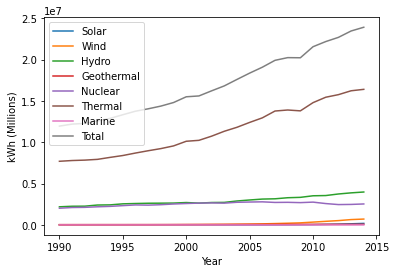

In [84]:
plt.plot(total_solar_production, label='Solar')
plt.plot(total_wind_production, label='Wind')
plt.plot(total_hydro_production, label='Hydro')
plt.plot(total_geothermal_production, label='Geothermal')
plt.plot(total_nuclear_production, label='Nuclear')
plt.plot(total_thermal_production, label='Thermal')
plt.plot(total_marine_production, label='Marine')
plt.plot(total_electricity_production, label='Total')

plt.xlabel('Year')
plt.ylabel('kWh (Millions)')
plt.legend()
plt.savefig('image1.png')

From this plot we can extract the following points:
- World electricity production doubled from 1990 to 2014.
- Thermal (non-renewable) energy is the most important source by far.
- All energy sources but nuclear increased in that time. Notably, there's been a decline in nuclear since 2005.
- Solar, wind, geothermal and marine production are almost negligible, but there's been an important increase since 2010, especially for wind.

## 2. What are the countries that have increased the most wind energy production?

To answer this and next questions, it will be useful to compute the difference between the production at two different years coming from every source. To do so, we will write two functions: one for the absolute difference, and one for the relative difference. The first one will help us determine what countries contribute the most to the global picture, and the second one will help us determine what are the countries that are making the greatest changes, but only locally.

In [85]:

def create_df_rel_increase_by_country(df, category, list_of_countries, from_year, to_year):
    """
    Function that returns a DataFrame with the relative difference of a given category in an interval of years.
    
    Input:
    - df: Dataframe that is used to compute the relative difference.
    - str category: It must be one of the categories of df.
    - list_of_countries: List containing the countries from which the relative increase will be obtained.
    - int from_year: Start year of the interval.
    - int to_year: End year of the interval.
    
    Output:
    - df_rel_increase: Dataframe with columns: Country, Relative Increment.
    """
    
    df_category = df[df['category'] == category] # Select category
    df_rel_increase = pd.DataFrame(columns=[]) # Initialize df_rel_increase
    

    
    for country in list_of_countries:
        
        # Write string used on df_rel_increase column
        string = category + '_rel_inc_' + str(from_year) + '_' + str(to_year)
        
        try:
            
            #   a. Select start, end year and country
            #   b. Obtain category specific production
            #   c. Obtain total production
            #   d. Compute relative production as ratio of b and c
            #   e. Compute difference
            
            # a
            select_cat_end = (df_category['year'] == to_year) & \
                             (df_category['country_or_area'] == country)
                
            select_cat_start = (df_category['year'] == from_year) & \
                               (df_category['country_or_area'] == country)
                
            select_tot_end = (df_electricity_production['year'] == to_year) & \
                             (df_electricity_production['country_or_area']==country)
                
            select_tot_start = (df_electricity_production['year'] == to_year) & \
                             (df_electricity_production['country_or_area'] == country)
                
            # b
            production_end = df_category[select_cat_end]['quantity'].values
                                
            production_start = df_category[select_cat_start]['quantity'].values
            
            # c
            total_end = df_electricity_production[select_tot_end]['quantity'].values
            
            total_start = df_electricity_production[select_tot_start]['quantity'].values
                                
            # d and e
            value = (production_end/total_end - production_start/total_start)
          
            # Add row with country and value to df_rel_increase    
            df_rel_increase=pd.concat([df_rel_increase, \
                                       pd.DataFrame({string: value}, index=[country])], axis=0)

        except: # If there is an error treat as NaN
            df_rel_increase=pd.concat([df_rel_increase, \
                                       pd.DataFrame({string: pd.NA}, index=[country])], axis=0)
    
    return df_rel_increase    

In [86]:
def create_df_increase_by_country(df, category, list_of_countries, from_year, to_year):
    """
    Function that returns a DataFrame with the difference of a given category in an interval of years.
    
    Input:
    - df: Dataframe that is used to compute the relative difference.
    - str category: It must be one of the categories of df.
    - list_of_countries: List containing the countries from which the relative increase will be obtained.
    - int from_year: Start year of the interval.
    - int to_year: End year of the interval.
    
    Output:
    - df_increase: Dataframe with columns: Country, Increment.
    """
    
    df_category = df[df['category'] == category] # Select category
    df_increase = pd.DataFrame(columns=[]) # Initialize df_increase
    
    string = category + '_inc_' + str(from_year) + '_' + str(to_year)
    
    for country in list_of_countries:
        
        try:
            #   a. Select start, end year and country
            #   b. Obtain category specific production for both years
            #   c. Compute production as ratio of b and c
            
            # a
            select_cat_end = (df_category['year'] == to_year) & \
                             (df_category['country_or_area'] == country)
                
            select_cat_start = (df_category['year'] == from_year) & \
                               (df_category['country_or_area'] == country)
                
            select_tot_end = (df_electricity_production['year'] == to_year) & \
                             (df_electricity_production['country_or_area']==country)
                
            select_tot_start = (df_electricity_production['year'] == to_year) & \
                             (df_electricity_production['country_or_area'] == country)
            
            # b
            production_end = df_category[select_cat_end]['quantity'].values
            
            production_start = df_category[select_cat_start]['quantity'].values
            
            # c
            value = production_end - production_start
            
            # Add row with country and value to df_increase
            df_increase=pd.concat([df_increase, \
                                   pd.DataFrame({string: value}, index=[country])], axis=0)

        except: # If there is an error treat as NaN
            df_increase=pd.concat([df_increase, \
                                   pd.DataFrame({string: pd.NA}, index=[country])], axis=0)
    
    return df_increase

Also, we will write another function to obtain a dataframe with the electricity structure for a list of countries in a given year. This will help us compare much more easily at a glimpse the structure of two different years by means of a pie chart.

In [87]:
def create_df_pool_by_country(df, list_of_countries, year):
    """
    Function that returns a DataFrame with the structure of the production
    of a given category in an interval of years.
    
    Input:
    - df: Dataframe that is used to compute the relative difference.
    - str list_of_countries: List containing the countries from which
                             the structure will be obtained.
    - int year.
    
    Output:
    - df_increase: Dataframe with columns Country and Increment.
    """
    
    categories = ['solar_electricity','hydro','nuclear_electricity',
                  'thermal_electricity','wind_electricity',
                  'tide_wave_and_ocean_electricity']

    df_pool = pd.DataFrame(columns = []) # Initialize df_pool
    
    for category in categories: # Loop all categories
        
        df_pool_cat = pd.DataFrame(columns = [category]) # Initialize df_pool_cat
        df_category = df[df['category'] == category] # Select category
                   
        for country in list_of_countries:
    
            try: 
                #   a. Select year and country.
                #   b. Obtain production.
                #   c. Add to dataframe.
                
                # a
                select = (df_category['year']==year) & \
                         (df_category['country_or_area']==country)
                # b
                value = df_category[select]['quantity'].values
                
                # c   
                df_pool_cat=pd.concat([df_pool_cat,pd.DataFrame({category: value}, \
                                                          index=[country]) \
                                   ], axis=0)

            except: # If there is an error add value as NaN.
                df_pool_cat=pd.concat([df_pool_cat,pd.DataFrame({category: pd.NA}, \
                                                          index=[country]) \
                                   ], axis=0)
        
        # Add new category to df_pool
        df_pool = pd.concat([df_pool,df_pool_cat], axis=1)
    
    
    return df_pool

We need to retrieve a list with all the countries that we are going to analyze:

In [88]:
list_of_countries = df['country_or_area'].unique()

Let's run it for year 2014, and create a pie chart for Spain.

In [89]:
df_pool = create_df_pool_by_country(df, list_of_countries, 2014)

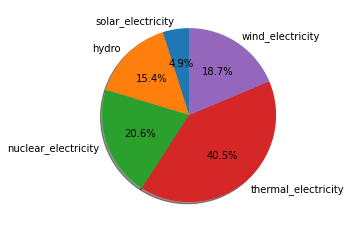

In [90]:
fig1, ax1 = plt.subplots()

df_pool_clean = df_pool.loc['Spain'].dropna(axis=0)

ax1.pie(df_pool_clean, labels=df_pool_clean.index, autopct='%1.1f%%', shadow=True, startangle=90)

#plt.show()

plt.savefig('image2.png')

Now, let's do the same for a decade earlier:

In [91]:
df_pool = create_df_pool_by_country(df, list_of_countries, 2004)

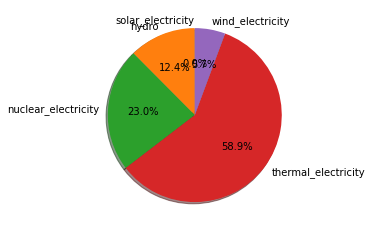

In [92]:
fig1, ax1 = plt.subplots()

df_pool_clean = df_pool.loc['Spain'].dropna(axis=0)

ax1.pie(df_pool_clean, labels=df_pool_clean.index, autopct='%1.1f%%', shadow=True, startangle=90)

#plt.show()

plt.savefig('image3.png')

From the comparison of both graphs we can extract the following:
- Thermal electricity, and nuclear electricity decreased, more the first one.
- Hydro increased slightly, wind doubled and solar exploded.

Although this is useful to focus on one country in particular, we need to use the functions created previously to analyze all the countries at the same time.

Now we are going to analyze what countries have had largest relative growth in wind energy production from 2004 to 2014. Since we will be using this variables in the rest of the study let's set them here.

In [93]:
from_year = 2004
to_year = 2014

In [94]:
wind_rel_increase_bycountry = create_df_rel_increase_by_country(df, \
                                                                'wind_electricity', \
                                                                list_of_countries, \
                                                                from_year, to_year)
# Sort in descending order and show to
wind_rel_increase_bycountry.sort_values('wind_electricity_rel_inc_' + \
                                        str(from_year) + '_' + str(to_year), \
                                        axis=0,ascending=False).head()

,wind_electricity_rel_inc_2004_2014
Falkland Is. (Malvinas),0.308215
Portugal,0.213912
Denmark,0.201846
Ireland,0.170442
Lithuania,0.145099


Malvinas, Denmark, and Portugal had the largest relative increase.

In [95]:
wind_increase_bycountry = create_df_increase_by_country(df, \
                                                        'wind_electricity', \
                                                        list_of_countries, \
                                                        from_year, to_year)
# Sort in descending order and show top 5
wind_increase_bycountry.sort_values('wind_electricity_inc_' +\
                                    str(from_year) + '_' + str(to_year), \
                                    axis=0,ascending=False).head()

,wind_electricity_inc_2004_2014
United States,169601.0
Spain,36313.0
Germany,31848.0
United Kingdom,30080.0
India,22762.0


For more detail let's create a procedure to plot a pie chart with all the countries. Note that we have to group all the countries with small growth in 'others' for better legibility. Also we need to allow for countries with negative values. That's why we need to separate all the countries in two different sets:
- One for the countries that had a positive increase.
- One for the countries that had a negative increase, or decrease.

We'll do this slicing by means of a boolean mask. Let's see what it looks like, and run it with 'wind_electricity':

In [141]:
def plot_pie_top_countries(source_increase, category, N, from_year, to_year, top=True):
    """ 
    Function that creates a pie chart with the countries that have greatest increment
    for a source of energy over an interval of years.
    
    Input:
    - source_increase: Dataframe containing the relative difference.
    - str category: category of energy, as in main dataframe.
    - int from_year: Start year of the interval.
    - int to_year: End year of the interval.
    - int N: Cut-value since which remaining countries are grouped.
    - Bool (top): set False to compute the negative increments.
    """

    fig1, ax1 = plt.subplots()

    # Multiply values by -1 for negative increments
    if top == True:
        coeff = 1
    else:
        coeff = -1
    
    source_increase_clean = coeff*source_increase.dropna(axis=0) # Drop NaN

    # Sort in descending order and take slice with N first
    source_increase_sorted = source_increase_clean[category + '_inc_' + \
                                               str(from_year) + '_' + str(to_year)]. \
                                               sort_values(ascending=False)[:N]
    # Obtain mask with positive values
    positive_values =        source_increase_clean[category + '_inc_' + \
                                               str(from_year) + '_' + str(to_year)]. \
                                               sort_values(ascending=False)>0
    # Compute sum of others including only positive values
    sum_others = source_increase_clean[category + '_inc_' + \
                                   str(from_year) + '_' + str(to_year)]. \
                                   sort_values(ascending=False) \
                                   [N:positive_values.sum()].values.sum()
    # Append others to slice with N first
    source_increase_sorted=source_increase_sorted.append(pd.Series({'others':sum_others}))

    ax1.pie(source_increase_sorted, labels=source_increase_sorted.index, \
        autopct='%1.1f%%', shadow=True, startangle=90)

    plt.savefig('image8.png')
    
    #plt.show()

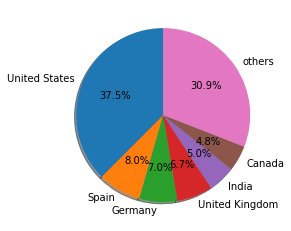

In [134]:
plot_pie_top_countries(wind_increase_bycountry, 'wind_electricity', 6, from_year, to_year)

United States, followed at great distance by Spain, and Germany, had the largest absolute increase.

## 3. What are the countries that have increased, and decreased, the most nuclear production?

In [98]:
nuclear_rel_increase_bycountry = create_df_rel_increase_by_country(df, \
                                                                   'nuclear_electricity', \
                                                                   list_of_countries, \
                                                                   from_year, to_year)
# Sort in descending order and show top 5
nuclear_rel_increase_bycountry.sort_values('nuclear_electricity_rel_inc_' + \
                                           str(from_year) + '_' + str(to_year), \
                                           axis=0,ascending=False).head()

,nuclear_electricity_rel_inc_2004_2014
Hungary,0.127132
Romania,0.093307
Slovenia,0.052245
"Korea, Republic of",0.046634
Czechia,0.046499


In [99]:
nuclear_increase_bycountry = create_df_increase_by_country(df, \
                                                           'nuclear_electricity', \
                                                           list_of_countries, \
                                                           from_year, to_year)
# Sort in descending order and show top 5
nuclear_increase_bycountry.sort_values('nuclear_electricity_inc_' + \
                                       str(from_year) + '_' + str(to_year), \
                                       axis=0,ascending=False).head()

,nuclear_electricity_inc_2004_2014
China,82069.0
Russian Federation,36050.0
"Korea, Republic of",25692.0
India,19091.0
Canada,17291.0


To obtain the pie chart with the top countries we use the procedure that we created before:

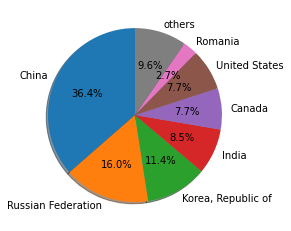

In [138]:
plot_pie_top_countries(nuclear_increase_bycountry, 'nuclear_electricity', 7, from_year, to_year)

We see that China leads the absolute top 5, and Hungary leads the relative top 5. It is interesting to see that at a time that overall the world was reducing nuclear energy, these countries were moving in a very different direction.

Now, what about the countries that decreased nuclear production? For the relative difference we proceed on the same way as before, but now setting ascending parameter to True:

In [101]:
# Sort in ascending order and show top 5
nuclear_rel_increase_bycountry.sort_values('nuclear_electricity_rel_inc_' + \
                                           str(from_year) + '_' + str(to_year), \
                                           axis=0,ascending=True).head()

,nuclear_electricity_rel_inc_2004_2014
Japan,-0.271402
Belgium,-0.187225
Germany,-0.111399
Sweden,-0.082057
Slovakia,-0.055728


For the absolute difference we proceed in an analogous way, now taking into account only the negative values by means of setting the optional parameter top to False.

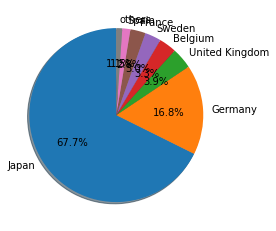

In [136]:
plot_pie_top_countries(nuclear_increase_bycountry,'nuclear_electricity', 7, from_year, to_year, False)

We see that Japan leads the countries dropping nuclear energy, followed by European countries which appear both in the absolute and relative top 5.

## 4. What are the countries that have increased, and decreased, the most thermal production?

In a similar way, for the top countries that have increased:

In [103]:
thermal_rel_increase_bycountry = create_df_rel_increase_by_country(df, \
                                                                   'thermal_electricity', \
                                                                   list_of_countries, \
                                                                   from_year, to_year)
# Sort in descending order and show top 5
thermal_rel_increase_bycountry.sort_values('thermal_electricity_rel_inc_' + \
                                           str(from_year) + '_' + str(to_year), \
                                           axis=0,ascending=False).head()

,thermal_electricity_rel_inc_2004_2014
Timor-Leste,0.808023
Guernsey,0.721268
Bahrain,0.689936
Qatar,0.657991
Jersey,0.657058


In [104]:
thermal_increase_bycountry = create_df_increase_by_country(df, \
                                                           'thermal_electricity', \
                                                           list_of_countries, \
                                                           from_year, to_year)
# Sort in descending order and show top 5
thermal_increase_bycountry.sort_values('thermal_electricity_inc_' + \
                                       str(from_year) + '_' + str(to_year), \
                                       axis=0,ascending=False).head()

,thermal_electricity_inc_2004_2014
China,2473061.2
India,551384.0
Japan,235644.0
Saudi Arabia,151930.0
"Korea, Republic of",150000.0


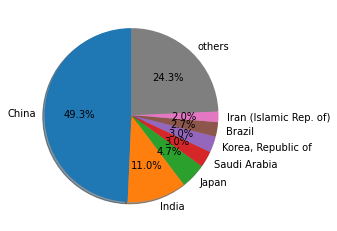

In [142]:
plot_pie_top_countries(thermal_increase_bycountry,'thermal_electricity', 7, from_year, to_year)

And for the countries that have relatively decreased:

In [106]:
# Sort in ascending order and show top 5
thermal_rel_increase_bycountry.sort_values('thermal_electricity_rel_inc_' + \
                                           str(from_year) + '_' + str(to_year), \
                                           axis=0,ascending=True).head()

,thermal_electricity_rel_inc_2004_2014
"China, Macao SAR",-2.078003
Jamaica,-0.771283
Luxembourg,-0.541625
Denmark,-0.476028
Palau,-0.437975


And absolutely:

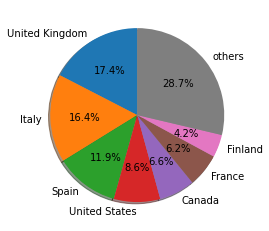

In [140]:
plot_pie_top_countries(thermal_increase_bycountry,'thermal_electricity', 7, from_year, to_year, False)

Finally, thermal electricity relatively increased the most in developing countries such as Tanzania, Haiti, or Congo. Lithuania and Latvia, although they are not developing countries they were affected by the USSR meltdown and experienced large growth during that decade. However, China and India lead the top 5 of absolute increases.

On the other hand we see decreases mostly in western countries. Although from the relative list we see that some developing countries such as Jamaica or Palau have largely reduced thermal energy production.

## 5. In what way population, and CO2 markets affect a transition to renewable energy?


Now, to answer our final question, we first need to create a dataframe with the countries that have a CO2 emissions market.

In [108]:
is_co2market = pd.DataFrame(np.full((len(list_of_countries),17),False), \
                            columns=range(1998,2015), index=list_of_countries)

EU_preETS = ['Austria','Belgium','Denmark','Finland','France','Germany','Greece',
               'Ireland','Italy','Luxembourg','Netherlands','Portugal','Spain','Sweden',
              'Cyprus','Czechia','Estonia','Hungary','Latvia','Lithuania','Malta','Poland',
               'Slovakia','Slovenia']

countries_2003 = ['Australia']
countries_2007 = ['Bulgaria','Romania','Canada']
countries_2008 = ['New Zealand']
countries_2009 = ['United States']
countries_2010 = ['Japan']

EU_2013 = ['Croatia']

for country in EU_preETS:
    is_co2market.loc[country,range(2005,2015)]=np.full(10,True)
    
for country in countries_2003:
    is_co2market.loc[country,range(2003,2015)]=np.full(12,True)

for country in countries_2007:
    is_co2market.loc[country,range(2007,2015)]=np.full(8,True)
    
for country in countries_2008:
    is_co2market.loc[country,range(2008,2015)]=np.full(7,True)
    
for country in countries_2009:
    is_co2market.loc[country,range(2009,2015)]=np.full(6,True)
    
for country in countries_2010:
    is_co2market.loc[country,range(2010,2015)]=np.full(5,True)


for country in EU_2013:
    is_co2market.loc[country,range(2013,2015)]=True
    
is_co2market

,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Austria,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True
Belgium,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True
Czechia,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True
Finland,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True
France,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tuvalu,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
United States Virgin Is.,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Wallis and Futuna Is.,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Commonwealth of Independent States (CIS),False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


We also need to read another file with the population of the different countries. To inspect it we'll show the head of it.

In [109]:
df_population = pd.read_csv('./Population.csv')

In [110]:
df_population.head()

,Series Name,Series Code,Country Name,Country Code,2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],...,2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021]
0,"Population, total",SP.POP.TOTL,Afghanistan,AFG,22600774,23680871,24726689,25654274,26433058,27100542,...,31161378,32269592,33370804,34413603,35383028,36296111,37171922,38041757,38928341,..
1,"Population, total",SP.POP.TOTL,Africa Eastern and Southern,AFE,419223717,430246635,441630149,453404076,465581372,478166911,...,547482863,562601578,578075373,593871847,609978946,626392880,643090131,660046272,677243299,..
2,"Population, total",SP.POP.TOTL,Africa Western and Central,AFW,281842480,289469530,297353098,305520588,313985474,322741656,...,370243017,380437896,390882979,401586651,412551299,423769930,435229381,446911598,458803476,..
3,"Population, total",SP.POP.TOTL,Albania,ALB,3051010,3039616,3026939,3011487,2992547,2970017,...,2900401,2895092,2889104,2880703,2876101,2873457,2866376,2854191,2837743,..
4,"Population, total",SP.POP.TOTL,Algeria,DZA,31855110,32264159,32692153,33149720,33641007,34166976,...,37383899,38140135,38923688,39728020,40551398,41389174,42228415,43053054,43851043,..


Let's create a dataframe with the current population, taking only year 2020.

In [111]:
population_bycountry = pd.DataFrame(columns=[])

for country in df_population['Country Name'].unique():

    try:
        value = df_population[df_population['Country Name']==country]['2020 [YR2020]'].values[0]
        population_bycountry=pd.concat([population_bycountry,pd.DataFrame({'population': value}, \
                                                                          index=[country])], axis=0)

    except:
        population_bycountry=pd.concat([population_bycountry,pd.DataFrame({'population': pd.NA}, \
                                                                          index=[country])], axis=0)

Now, let's create two functions to compute the relative and absolute increment of population given a set of two different years.

In [112]:
def create_df_population_inc_by_country(df, from_year, to_year):
    """
    Function that returns a DataFrame with the difference of population in an interval of years.
    
    Input:
    - df: Dataframe that is used to compute the relative difference.
    - int from_year: Start year of the interval.
    - int to_year: End year of the interval.
    
    Output:
    - population_inc_by_country: Dataframe with columns: Country, Increment.
    """
    
    population_inc_bycountry = pd.DataFrame(columns=[])

    for country in df_population['Country Name'].unique():

        try:
            population_new = int(df_population[df_population['Country Name']==country] \
                                 [str(to_year) + ' [YR' + str(to_year) + ']'].values[0])
            population_old = int(df_population[df_population['Country Name']==country] \
                                 [str(from_year) + ' [YR' + str(from_year) + ']'].values[0])
            
            value = population_new - population_old
                                                                           
            population_inc_bycountry=pd.concat([population_inc_bycountry, \
                                                pd.DataFrame({'population_inc_' + \
                                                              str(from_year) + '_' + str(to_year): value}, \
                                                index=[country])], axis=0)

        except:
            population_inc_bycountry=pd.concat([population_inc_bycountry, \
                                                pd.DataFrame({'population_inc_' + \
                                                              str(from_year) + '_' + str(to_year): pd.NA}, \
                                                index=[country])], axis=0)
            
    return population_inc_bycountry


In [113]:
def create_df_population_rel_inc_by_country(df, from_year, to_year):
    """
    Function that returns a DataFrame with the relative difference of population in an interval of years.
    
    Input:
    - df: Dataframe that is used to compute the relative difference.
    - int from_year: Start year of the interval.
    - int to_year: End year of the interval.
    
    Output:
    - population_rel_inc_by_country: Dataframe with columns: Country, Increment.
    """
    
    population_rel_inc_bycountry = pd.DataFrame(columns=[])
    
    for country in df_population['Country Name'].unique():

        try:
            population_new = int(df_population[df_population['Country Name']==country] \
                                 [str(to_year) + ' [YR' + str(to_year) + ']'].values[0])
            population_old = int(df_population[df_population['Country Name']==country] \
                                 [str(from_year) + ' [YR' + str(from_year) + ']'].values[0])
            
            value = (population_new - population_old) / population_old
                                                                           
            population_rel_inc_bycountry=pd.concat([population_rel_inc_bycountry, \
                                                    pd.DataFrame({'population_rel_inc_' + \
                                                                  str(from_year) + '_' + str(to_year): value}, \
                                                    index=[country])], axis=0)

        except:
            population_rel_inc_bycountry=pd.concat([population_rel_inc_bycountry, \
                                                    pd.DataFrame({'population_rel_inc_' + \
                                                                  str(from_year) + '_' + str(to_year): pd.NA}, \
                                                    index=[country])], axis=0)
            
    return population_rel_inc_bycountry

We run this two functions for the interval that we are studying.

In [114]:
population_increase_bycountry = create_df_population_inc_by_country(df_population, from_year, to_year)

In [115]:
population_rel_increase_bycountry = create_df_population_rel_inc_by_country(df_population, from_year, to_year)

Now let's join the following into one dataframe df_all:
- Boolean variable representing if there was or there was not a CO2 trading market in place three years before the last year of the interval that we are studying.
- All the different energy sources increases, we still need to compute some.
- Population in the middle of the interval.
- Population relative increase during the interval.

In [116]:
middle_year = from_year + (to_year - from_year)//2

Let's compute the increases for solar, hydro, geothermal, and marine:

In [117]:
solar_increase_bycountry = create_df_increase_by_country(df, 'solar_electricity', \
                                                         list_of_countries, from_year, to_year)
hydro_increase_bycountry = create_df_increase_by_country(df, 'hydro', \
                                                         list_of_countries, from_year, to_year)
geothermal_increase_bycountry = create_df_increase_by_country(df, 'geothermal', \
                                                              list_of_countries, from_year, to_year)
marine_increase_bycountry = create_df_increase_by_country(df, 'marine', \
                                                          list_of_countries, from_year, to_year)

In [118]:
solar_rel_increase_bycountry = create_df_rel_increase_by_country(df, 'solar_electricity', \
                                                                 list_of_countries, from_year, to_year)
hydro_rel_increase_bycountry = create_df_rel_increase_by_country(df, 'hydro', \
                                                                 list_of_countries, from_year, to_year)
geothermal_rel_increase_bycountry = create_df_rel_increase_by_country(df, 'geothermal', \
                                                                      list_of_countries, from_year, to_year)
marine_rel_increase_bycountry = create_df_rel_increase_by_country(df, 'marine', \
                                                                  list_of_countries, from_year, to_year)

In [119]:
middle_year

2009

In [120]:
df_all = population_bycountry.join(population_rel_increase_bycountry)

list_data = [
    is_co2market[middle_year],
    solar_increase_bycountry,
    solar_rel_increase_bycountry,
    thermal_increase_bycountry,
    thermal_rel_increase_bycountry,
    geothermal_increase_bycountry,
    geothermal_rel_increase_bycountry,
    hydro_increase_bycountry,
    hydro_rel_increase_bycountry,
    wind_increase_bycountry,
    wind_rel_increase_bycountry,
    nuclear_increase_bycountry,
    nuclear_rel_increase_bycountry,
    marine_increase_bycountry,
    marine_rel_increase_bycountry,    
]

for data in list_data:
    
    df_all = df_all.join(data)

We rename some columns and drop all the rows with no values at thermal electricity increment. We choose thermal electricity because it is the most conventional form of energy. Our aim is to isolate the rows that have energy data. Others might be regions, or countries not contained in the energy dataset.

In [121]:
df_all=df_all.rename(columns={middle_year: 'is_co2market_' + str(middle_year)})
df_all=df_all.dropna(subset=['thermal_electricity_inc_' + str(from_year) + '_' + str(to_year)], axis=0)

In [122]:
df_all

,population,population_rel_inc_2004_2014,is_co2market_2009,solar_electricity_inc_2004_2014,solar_electricity_rel_inc_2004_2014,thermal_electricity_inc_2004_2014,thermal_electricity_rel_inc_2004_2014,geothermal_inc_2004_2014,geothermal_rel_inc_2004_2014,hydro_inc_2004_2014,hydro_rel_inc_2004_2014,wind_electricity_inc_2004_2014,wind_electricity_rel_inc_2004_2014,nuclear_electricity_inc_2004_2014,nuclear_electricity_rel_inc_2004_2014,marine_inc_2004_2014,marine_rel_inc_2004_2014
Afghanistan,38928341,0.349586,False,NaN,NaN,-61.000,-0.058134,NaN,NaN,330.30,0.314781,NaN,NaN,NaN,NaN,NaN,NaN
Algeria,43851043,0.190613,False,NaN,NaN,32989.000,0.513511,NaN,NaN,3.00,0.000047,NaN,NaN,NaN,NaN,NaN,NaN
American Samoa,55197,-0.065227,False,NaN,NaN,-32.255,-0.205518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Andorra,77265,0.038859,False,NaN,NaN,12.400,0.097792,NaN,NaN,20.40,0.160883,NaN,NaN,NaN,NaN,NaN,NaN
Angola,32866268,0.436271,False,NaN,NaN,3949.000,0.416561,NaN,NaN,3291.00,0.347152,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uruguay,3473727,0.023770,False,NaN,NaN,1504.000,0.115620,NaN,NaN,4869.10,0.374313,NaN,NaN,NaN,NaN,NaN,NaN
Uzbekistan,34232050,0.189193,False,NaN,NaN,2580.000,0.046570,NaN,NaN,2820.00,0.050903,NaN,NaN,NaN,NaN,NaN,NaN
Vanuatu,307150,0.292789,False,NaN,NaN,8.910,0.133784,NaN,NaN,5.53,0.083033,NaN,NaN,NaN,NaN,NaN,NaN
Zambia,18383956,0.333241,False,NaN,NaN,363.000,0.025118,NaN,NaN,5582.00,0.386244,NaN,NaN,NaN,NaN,NaN,NaN


Now, we are going to group renewable and non renewable energies, and add it to our dataset, dropping the original columns.

In [123]:
columns_inc_renewable = [
    'solar_electricity_inc_' + str(from_year) + '_' + str(to_year),
    'hydro_inc_' + str(from_year) + '_' + str(to_year),
    'wind_electricity_inc_' + str(from_year) + '_' + str(to_year),
    'geothermal_inc_' + str(from_year) + '_' + str(to_year),
    'marine_inc_' + str(from_year) + '_' + str(to_year)
]

columns_inc_non_renewable = [
    'thermal_electricity_inc_' + str(from_year) + '_' + str(to_year),
    'nuclear_electricity_inc_' + str(from_year) + '_' + str(to_year)
]

columns_rel_inc_renewable = [
    'solar_electricity_rel_inc_' + str(from_year) + '_' + str(to_year),
    'hydro_rel_inc_' + str(from_year) + '_' + str(to_year),
    'wind_electricity_rel_inc_' + str(from_year) + '_' + str(to_year),
    'geothermal_rel_inc_' + str(from_year) + '_' + str(to_year),
    'marine_rel_inc_' + str(from_year) + '_' + str(to_year)
]

columns_rel_inc_non_renewable = [
    'thermal_electricity_rel_inc_' + str(from_year) + '_' + str(to_year),
    'nuclear_electricity_rel_inc_' + str(from_year) + '_' + str(to_year)
]


#df_all['renewable_rel_inc_2004_2014'] = df_all[columns_rel_inc_renewable].sum(axis=1)
df_all['renewable_inc_' + str(from_year) + '_' + str(to_year)] = \
                        df_all[columns_inc_renewable].sum(axis=1)



df_all = df_all.drop(columns_inc_renewable, axis=1)
df_all = df_all.drop(columns_inc_non_renewable, axis=1)
df_all = df_all.drop(columns_rel_inc_renewable, axis=1)
df_all = df_all.drop(columns_rel_inc_non_renewable, axis=1)


This is how our dataframe looks like:

In [124]:
df_all.head()

,population,population_rel_inc_2004_2014,is_co2market_2009,renewable_inc_2004_2014
Afghanistan,38928341,0.349586,False,330.3
Algeria,43851043,0.190613,False,3.0
American Samoa,55197,-0.065227,False,0.0
Andorra,77265,0.038859,False,20.4
Angola,32866268,0.436271,False,3291.0


And finally we can apply a linear model to see the influence of each factor on the increment of renewable energy:

## Data modeling

In [125]:
response_col = 'renewable_inc_' + str(from_year) + '_' + str(to_year)
test_size = 0.3
rand_state=24
df_all_clean= df_all.dropna()
X = df_all_clean.drop(response_col, axis=1)
y = df_all_clean['renewable_inc_' + str(from_year) + '_' + str(to_year)]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=rand_state)
lm_model = LinearRegression(normalize = True)
lm_model.fit(X_train, y_train)
y_train_pred = lm_model.predict(X_train)
X_train
y_test_pred = lm_model.predict(X_test)
test_score = r2_score(y_test,y_test_pred)
train_score = r2_score(y_train,y_train_pred)

In [126]:
test_score

0.4361140153594091

In [127]:
train_score

0.5793789331448926

Our train and test scores are very similar, but quite low. However, this doesn't mean that the model is not significant.

In [128]:
X_train.columns

Index(['population', 'population_rel_inc_2004_2014', 'is_co2market_2009'], dtype='object')

In [129]:
lm_coefs = lm_model.coef_

Instead of looking directly at the coefficients we are going to weigh them by the standard deviation, so that we can compare them on the same basis:

In [130]:
print('coeff1 * std1: ' + str(lm_model.coef_[0]*X['population'].values.astype(int).std()))

coeff1 * std1: 42833.01228375654


In [131]:
print('coeff2 * std2: ' + str(lm_model.coef_[1]*X['population_rel_inc_' + str(from_year) \
                                + '_' + str(to_year)].values.astype(int).max()))

coeff2 * std2: -3071.4046125818086


In [132]:
print('coeff3 * std3: ' + str(lm_model.coef_[2]*X['is_co2market_' + str(middle_year)]. \
                              values.astype(int).max()))

coeff3 * std3: 16250.84846659304


From this coefficients we can extract the following conclusions: 
- Larger populations tend to have more renewable energy production. This is the most important factor.
- Having a CO2 market does seem to have a great impact, showing greater increases in renewable energy production.
- Big population growth correlates with a tendency to have less renewable energy production. However this factor is the weakest in our model.

# 